# Rotation Prediction Pipeline

End-to-end pipeline comparing **10-minute** vs **15-minute** opening windows across the full 3-year MNQ dataset (Jan 2023 – Jan 2026).

**Pipeline stages:**
1. `mp2b_IBH_IBL.py` — Initial Balance metrics & opening range
2. `mp2a_previous_day_levels.py` — Prior-day contextual levels
3. Feature engineering (same 5 features used by `mp3_analysis_variables.py`)
4. Model training — Decision Tree & Random Forest with SMOTE
5. Cross-validation report & side-by-side comparison
6. Best model export

In [1]:
import subprocess, os, sys, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings("ignore", category=FutureWarning)

BASE_DIR = os.path.abspath(".")
CSV_PATH = os.path.join(BASE_DIR, "MNQ_1min_2023Jan_2026Jan.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Full 3-year range
START_DATE = "2023-01-02"
END_DATE   = "2026-01-15"

# Opening windows to compare
OPENING_WINDOWS = [10, 15]

# Volume normalization parameters
# - opening_bar_volume normalized by rolling average matching opening window (10 or 15 days)
# - prev_session_volume normalized by rolling average of N days
PREV_SESSION_VOL_NORM_WINDOW = 10  # days

# Feature columns — now using NORMALIZED volume features
FEATURE_COLS = [
    "relative_ib_volume",
    "normalized_distance",
    "opening_bar_open_close",
    "norm_opening_bar_volume",      # NEW: opening_bar_volume / rolling avg
    "norm_prev_session_volume",     # NEW: prev_session_volume / rolling avg
]

# Original feature columns (for comparison)
FEATURE_COLS_ORIGINAL = [
    "relative_ib_volume",
    "normalized_distance",
    "opening_bar_open_close",
    "opening_bar_volume",
    "prev_session_volume",
]

print(f"Data file:  {CSV_PATH}")
print(f"Date range: {START_DATE} → {END_DATE}")
print(f"Opening windows: {OPENING_WINDOWS} minutes")
print(f"Volume normalization: opening_bar uses {OPENING_WINDOWS}-day rolling avg (per config)")
print(f"                      prev_session uses {PREV_SESSION_VOL_NORM_WINDOW}-day rolling avg")

Data file:  /home/user/initialbalanceanalysis/MNQ_1min_2023Jan_2026Jan.csv
Date range: 2023-01-02 → 2026-01-15
Opening windows: [10, 15] minutes
Volume normalization: opening_bar uses [10, 15]-day rolling avg (per config)
                      prev_session uses 10-day rolling avg


## 1. Run Pipeline Stages (mp2b → mp2a) for Each Opening Window

In [2]:
def run_pipeline(opening_minutes: int) -> str:
    """Run mp2b then mp2a for a given opening window. Returns path to phase2 CSV."""
    tag = f"{opening_minutes}min"
    ib_out = os.path.join(OUTPUT_DIR, f"ib_metrics_{tag}.csv")
    p2_out = os.path.join(OUTPUT_DIR, f"phase2_{tag}.csv")

    # --- mp2b: IB metrics ---
    cmd_mp2b = [
        sys.executable, os.path.join(BASE_DIR, "mp2b_IBH_IBL.py"),
        "--csv", CSV_PATH,
        "--start-date", START_DATE,
        "--end-date", END_DATE,
        "--opening-window-minutes", str(opening_minutes),
        "--output", ib_out,
    ]
    print(f"  mp2b ({tag})... ", end="", flush=True)
    result = subprocess.run(cmd_mp2b, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"FAILED\n{result.stderr}")
        raise RuntimeError(f"mp2b failed for {tag}")
    print("done")

    # --- mp2a: prior-day levels ---
    cmd_mp2a = [
        sys.executable, os.path.join(BASE_DIR, "mp2a_previous_day_levels.py"),
        "--csv", CSV_PATH,
        "--ib-metrics", ib_out,
        "--output", p2_out,
    ]
    print(f"  mp2a ({tag})... ", end="", flush=True)
    result = subprocess.run(cmd_mp2a, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"FAILED\n{result.stderr}")
        raise RuntimeError(f"mp2a failed for {tag}")
    print("done")

    return p2_out


phase2_paths = {}
for win in OPENING_WINDOWS:
    print(f"\nRunning pipeline for {win}-minute opening window:")
    phase2_paths[win] = run_pipeline(win)

print("\nAll pipeline runs complete.")
for win, path in phase2_paths.items():
    print(f"  {win} min → {path}")


Running pipeline for 10-minute opening window:
  mp2b (10min)... 

done
  mp2a (10min)... 

done

Running pipeline for 15-minute opening window:
  mp2b (15min)... 

done
  mp2a (15min)... 

done

All pipeline runs complete.
  10 min → /home/user/initialbalanceanalysis/outputs/phase2_10min.csv
  15 min → /home/user/initialbalanceanalysis/outputs/phase2_15min.csv


## 2. Load & Prepare Features

In [3]:
def load_and_prepare(csv_path: str, opening_window: int) -> tuple[pd.DataFrame, pd.Series]:
    """Load phase2 CSV and return (X, y) with normalized volume features.
    
    Args:
        csv_path: Path to phase2 CSV
        opening_window: Opening window in minutes (used for opening_bar_volume normalization window)
    """
    df = pd.read_csv(csv_path)
    df["session_date"] = pd.to_datetime(df["session_date"])
    df = df.sort_values("session_date").reset_index(drop=True)

    # Normalized distance: nearest_prior_level_to_open_distance / (prev_pdh - prev_pdl)
    df["prev_range"] = df["prev_pdh"] - df["prev_pdl"]
    df["prev_range"] = df["prev_range"].replace(0, np.nan)
    df["normalized_distance"] = (
        df["nearest_prior_level_to_open_distance"] / df["prev_range"]
    )
    df["normalized_distance"] = df["normalized_distance"].fillna(0)

    # --- Normalized volume features ---
    # Use .shift(1) so we only use PAST data (no look-ahead bias)
    
    # opening_bar_volume: normalize by rolling avg of past N days (N = opening_window)
    df["avg_opening_bar_volume"] = (
        df["opening_bar_volume"]
        .rolling(window=opening_window, min_periods=1)
        .mean()
        .shift(1)
    )
    df["norm_opening_bar_volume"] = df["opening_bar_volume"] / df["avg_opening_bar_volume"]
    
    # prev_session_volume: normalize by rolling avg of past N days (N = PREV_SESSION_VOL_NORM_WINDOW)
    df["avg_prev_session_volume"] = (
        df["prev_session_volume"]
        .rolling(window=PREV_SESSION_VOL_NORM_WINDOW, min_periods=1)
        .mean()
        .shift(1)
    )
    df["norm_prev_session_volume"] = df["prev_session_volume"] / df["avg_prev_session_volume"]

    X = df[FEATURE_COLS].copy()
    y = df["rotation"].copy()

    # Drop rows with NaN features (first few rows won't have enough history)
    mask = X.dropna().index
    X = X.loc[mask]
    y = y.loc[mask]

    return X, y


datasets = {}
for win in OPENING_WINDOWS:
    X, y = load_and_prepare(phase2_paths[win], opening_window=win)
    datasets[win] = (X, y)
    rot_count = y.sum()
    print(f"{win}-min window: {len(y)} sessions, {rot_count} rotations ({rot_count/len(y)*100:.1f}%), {len(y)-rot_count} non-rotations ({(len(y)-rot_count)/len(y)*100:.1f}%)")

# Show sample of normalized features
print("\nSample of normalized volume features (10-min):")
sample_df = pd.read_csv(phase2_paths[10])
sample_df["session_date"] = pd.to_datetime(sample_df["session_date"])
sample_df = sample_df.sort_values("session_date").reset_index(drop=True)
sample_df["avg_opening_bar_volume"] = sample_df["opening_bar_volume"].rolling(10, min_periods=1).mean().shift(1)
sample_df["norm_opening_bar_volume"] = sample_df["opening_bar_volume"] / sample_df["avg_opening_bar_volume"]
sample_df["avg_prev_session_volume"] = sample_df["prev_session_volume"].rolling(10, min_periods=1).mean().shift(1)
sample_df["norm_prev_session_volume"] = sample_df["prev_session_volume"] / sample_df["avg_prev_session_volume"]
display(sample_df[["session_date", "opening_bar_volume", "avg_opening_bar_volume", "norm_opening_bar_volume", 
                   "prev_session_volume", "avg_prev_session_volume", "norm_prev_session_volume"]].tail(10))

10-min window: 764 sessions, 156 rotations (20.4%), 608 non-rotations (79.6%)
15-min window: 764 sessions, 156 rotations (20.4%), 608 non-rotations (79.6%)

Sample of normalized volume features (10-min):


,session_date,opening_bar_volume,avg_opening_bar_volume,norm_opening_bar_volume,prev_session_volume,avg_prev_session_volume,norm_prev_session_volume
755,2026-01-02,12407.0,10563.9,1.174472,771319.0,792605.8,0.973143
756,2026-01-05,13730.0,10704.3,1.282662,1389399.0,835893.2,1.662173
757,2026-01-06,14917.0,10718.2,1.391745,997500.0,832114.5,1.198753
758,2026-01-07,12769.0,10926.0,1.168680,1073660.0,787099.9,1.364071
759,2026-01-08,14759.0,11252.4,1.311631,1117205.0,797569.2,1.400762
760,2026-01-09,15876.0,11322.2,1.402201,1286976.0,830300.7,1.550012
761,2026-01-12,15493.0,12032.7,1.287575,1253557.0,893057.1,1.403669
762,2026-01-13,15362.0,12685.6,1.210979,913739.0,989235.3,0.923682
763,2026-01-14,11375.0,13202.4,0.861586,1440791.0,1029374.3,1.399676
764,2026-01-15,14873.0,13401.9,1.109768,1787488.0,1093199.9,1.635097


## 3. Cross-Validation Report

We use `imblearn.pipeline.Pipeline` so that SMOTE is applied **inside** each CV fold (only on training data), preventing data leakage.

Scoring metrics:
- **F1** — harmonic mean of precision and recall; the single best metric for imbalanced binary classification
- **Accuracy** — overall correctness (can be misleading when classes are imbalanced)
- **Precision** — of predicted rotations, how many actually were
- **Recall** — of actual rotations, how many did the model catch

In [4]:
def run_cross_validation(X, y, model, model_name, n_splits=5):
    """Run stratified K-fold CV with SMOTE inside each fold. Returns scores dict."""
    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("model", model),
    ])
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scoring = ["accuracy", "f1", "precision", "recall"]
    results = cross_validate(
        pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False
    )
    return results


# Model configurations
model_configs = {
    "Decision Tree (depth=3)": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Random Forest (100 trees, depth=5)": RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
}

cv_results = {}  # {(window, model_name): results_dict}

for win in OPENING_WINDOWS:
    X, y = datasets[win]
    for model_name, model in model_configs.items():
        print(f"CV: {win}-min / {model_name} ... ", end="", flush=True)
        results = run_cross_validation(X, y, model, model_name, n_splits=5)
        cv_results[(win, model_name)] = results
        f1 = results["test_f1"]
        print(f"F1 = {f1.mean():.3f} ± {f1.std():.3f}")

CV: 10-min / Decision Tree (depth=3) ... 

F1 = 0.420 ± 0.032
CV: 10-min / Random Forest (100 trees, depth=5) ... 

F1 = 0.451 ± 0.022
CV: 15-min / Decision Tree (depth=3) ... 

F1 = 0.415 ± 0.033
CV: 15-min / Random Forest (100 trees, depth=5) ... 

F1 = 0.407 ± 0.026


In [5]:
# Build comparison table
rows = []
for (win, model_name), res in cv_results.items():
    rows.append({
        "Opening Window": f"{win} min",
        "Model": model_name,
        "Accuracy": f"{res['test_accuracy'].mean():.3f} ± {res['test_accuracy'].std():.3f}",
        "F1": f"{res['test_f1'].mean():.3f} ± {res['test_f1'].std():.3f}",
        "Precision": f"{res['test_precision'].mean():.3f} ± {res['test_precision'].std():.3f}",
        "Recall": f"{res['test_recall'].mean():.3f} ± {res['test_recall'].std():.3f}",
    })

cv_table = pd.DataFrame(rows)
print("\n5-Fold Stratified Cross-Validation (SMOTE applied per fold)")
print("=" * 90)
display(cv_table)


5-Fold Stratified Cross-Validation (SMOTE applied per fold)


,Opening Window,Model,Accuracy,F1,Precision,Recall
0,10 min,Decision Tree (depth=3),0.596 ± 0.069,0.420 ± 0.032,0.302 ± 0.034,0.717 ± 0.135
1,10 min,"Random Forest (100 trees, depth=5)",0.665 ± 0.035,0.451 ± 0.022,0.341 ± 0.026,0.673 ± 0.043
2,15 min,Decision Tree (depth=3),0.630 ± 0.048,0.415 ± 0.033,0.310 ± 0.036,0.640 ± 0.068
3,15 min,"Random Forest (100 trees, depth=5)",0.639 ± 0.034,0.407 ± 0.026,0.307 ± 0.018,0.608 ± 0.079


### How to read the CV results

| Metric | What it tells you | Why it matters here |
|--------|-------------------|--------------------|
| **F1** | Balance between precision and recall | Primary metric — a low F1 (like the prior 0.42) means the model struggles to reliably identify rotations without also generating false positives |
| **Precision** | "When the model says rotation, how often is it right?" | High precision = fewer false alarms. Important if you act on predictions (e.g., position sizing) |
| **Recall** | "Of all actual rotations, how many does the model catch?" | High recall = fewer missed opportunities. SMOTE boosts this by giving the model more rotation examples |
| **Accuracy** | Overall % correct | Can be misleading — a model that always predicts non-rotation gets ~70% accuracy on an imbalanced set |
| **± std** | Stability across folds | Large std means the model is sensitive to which data it trains on — a sign of overfitting or insufficient data |

**Guidance:**
- F1 > 0.50 is a meaningful improvement over the prior baseline (0.42)
- If Random Forest F1 is materially higher than Decision Tree, the extra complexity is justified
- If 15-min window improves F1, the wider opening range captures more signal about the session's direction
- If std is high (> 0.10), the model may not generalize well to unseen data

## 4. Train Final Models (60/40 Split with SMOTE)

In [6]:
# Train all 4 combinations on 60/40 split
trained_models = {}  # {(window, model_name): {model, X_test, y_test, y_pred, ...}}

for win in OPENING_WINDOWS:
    X, y = datasets[win]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    for model_name, model_template in model_configs.items():
        # Clone the model so each gets fresh parameters
        from sklearn.base import clone
        model = clone(model_template)
        model.fit(X_train_sm, y_train_sm)

        y_pred = model.predict(X_test)
        test_acc = model.score(X_test, y_test)
        train_acc = model.score(X_train_sm, y_train_sm)

        trained_models[(win, model_name)] = {
            "model": model,
            "X_test": X_test,
            "y_test": y_test,
            "y_pred": y_pred,
            "test_acc": test_acc,
            "train_acc": train_acc,
        }
        print(f"{win}-min / {model_name}: train acc = {train_acc:.3f}, test acc = {test_acc:.3f}")

10-min / Decision Tree (depth=3): train acc = 0.736, test acc = 0.683


10-min / Random Forest (100 trees, depth=5): train acc = 0.848, test acc = 0.670


15-min / Decision Tree (depth=3): train acc = 0.739, test acc = 0.660


15-min / Random Forest (100 trees, depth=5): train acc = 0.842, test acc = 0.680


## 5. Decision Tree Reports


  Decision Tree — 10-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.86      0.72      0.78       244
    Rotation       0.33      0.55      0.41        62

    accuracy                           0.68       306
   macro avg       0.60      0.63      0.60       306
weighted avg       0.75      0.68      0.71       306



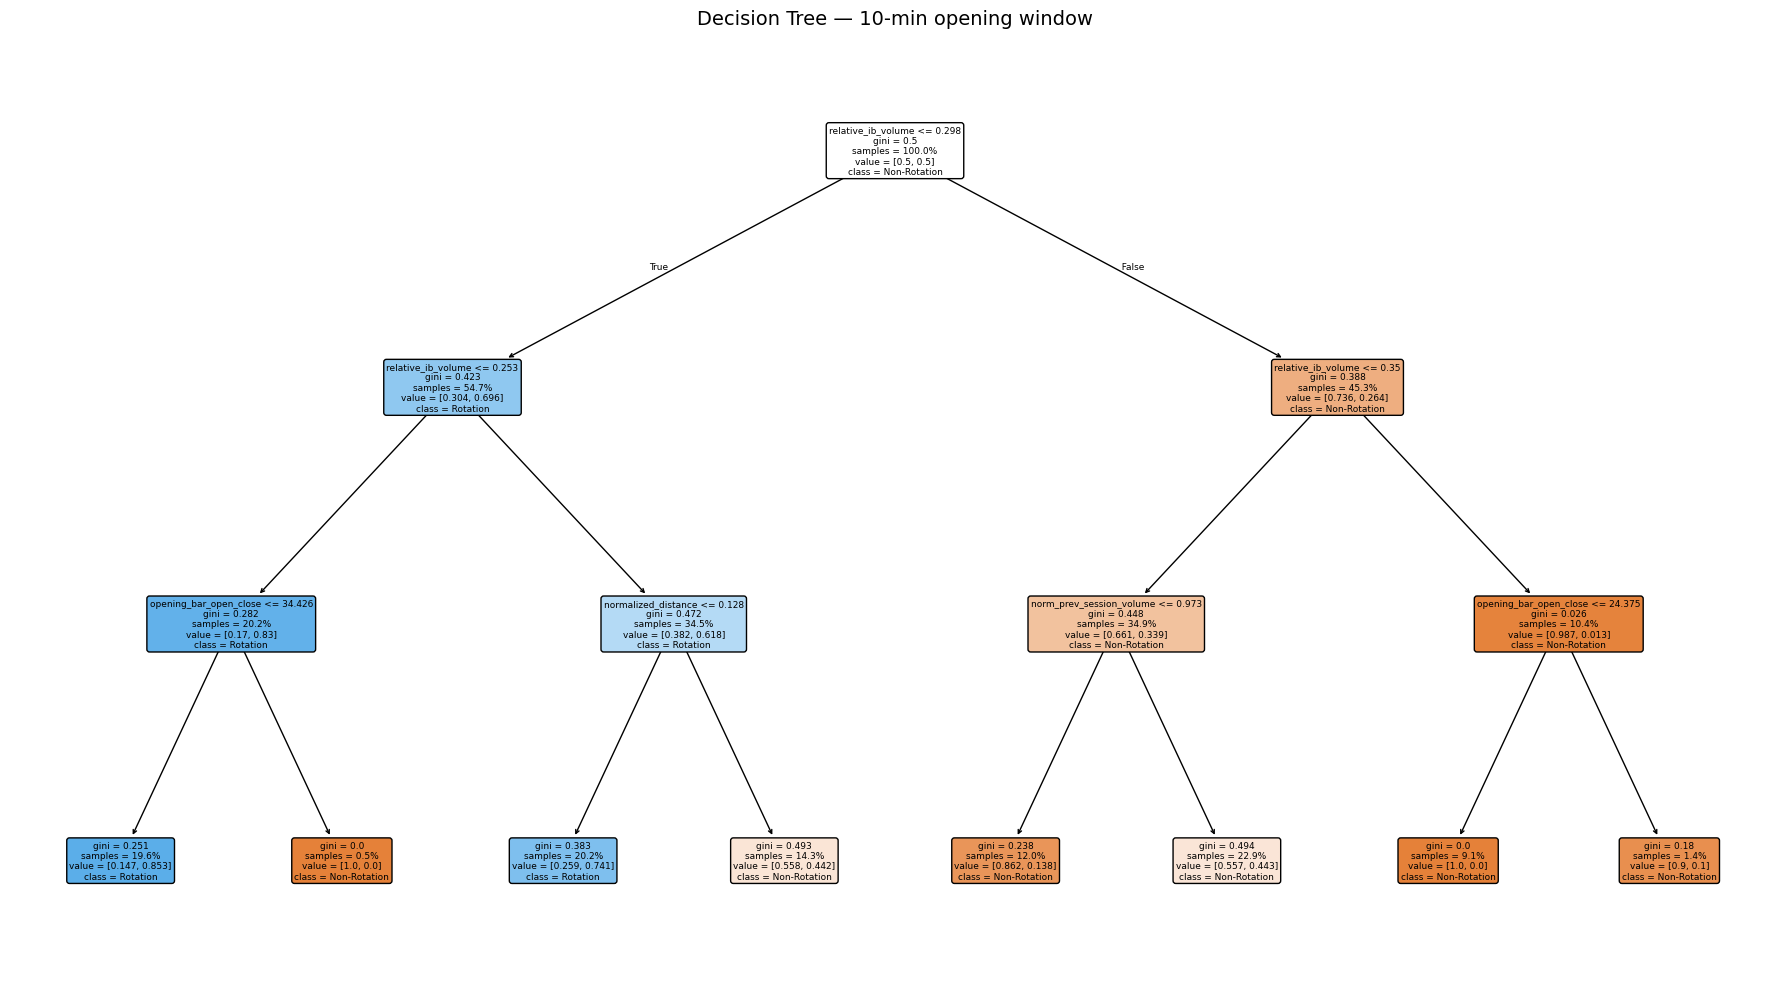


  Decision Tree — 15-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.88      0.66      0.76       244
    Rotation       0.33      0.66      0.44        62

    accuracy                           0.66       306
   macro avg       0.61      0.66      0.60       306
weighted avg       0.77      0.66      0.69       306



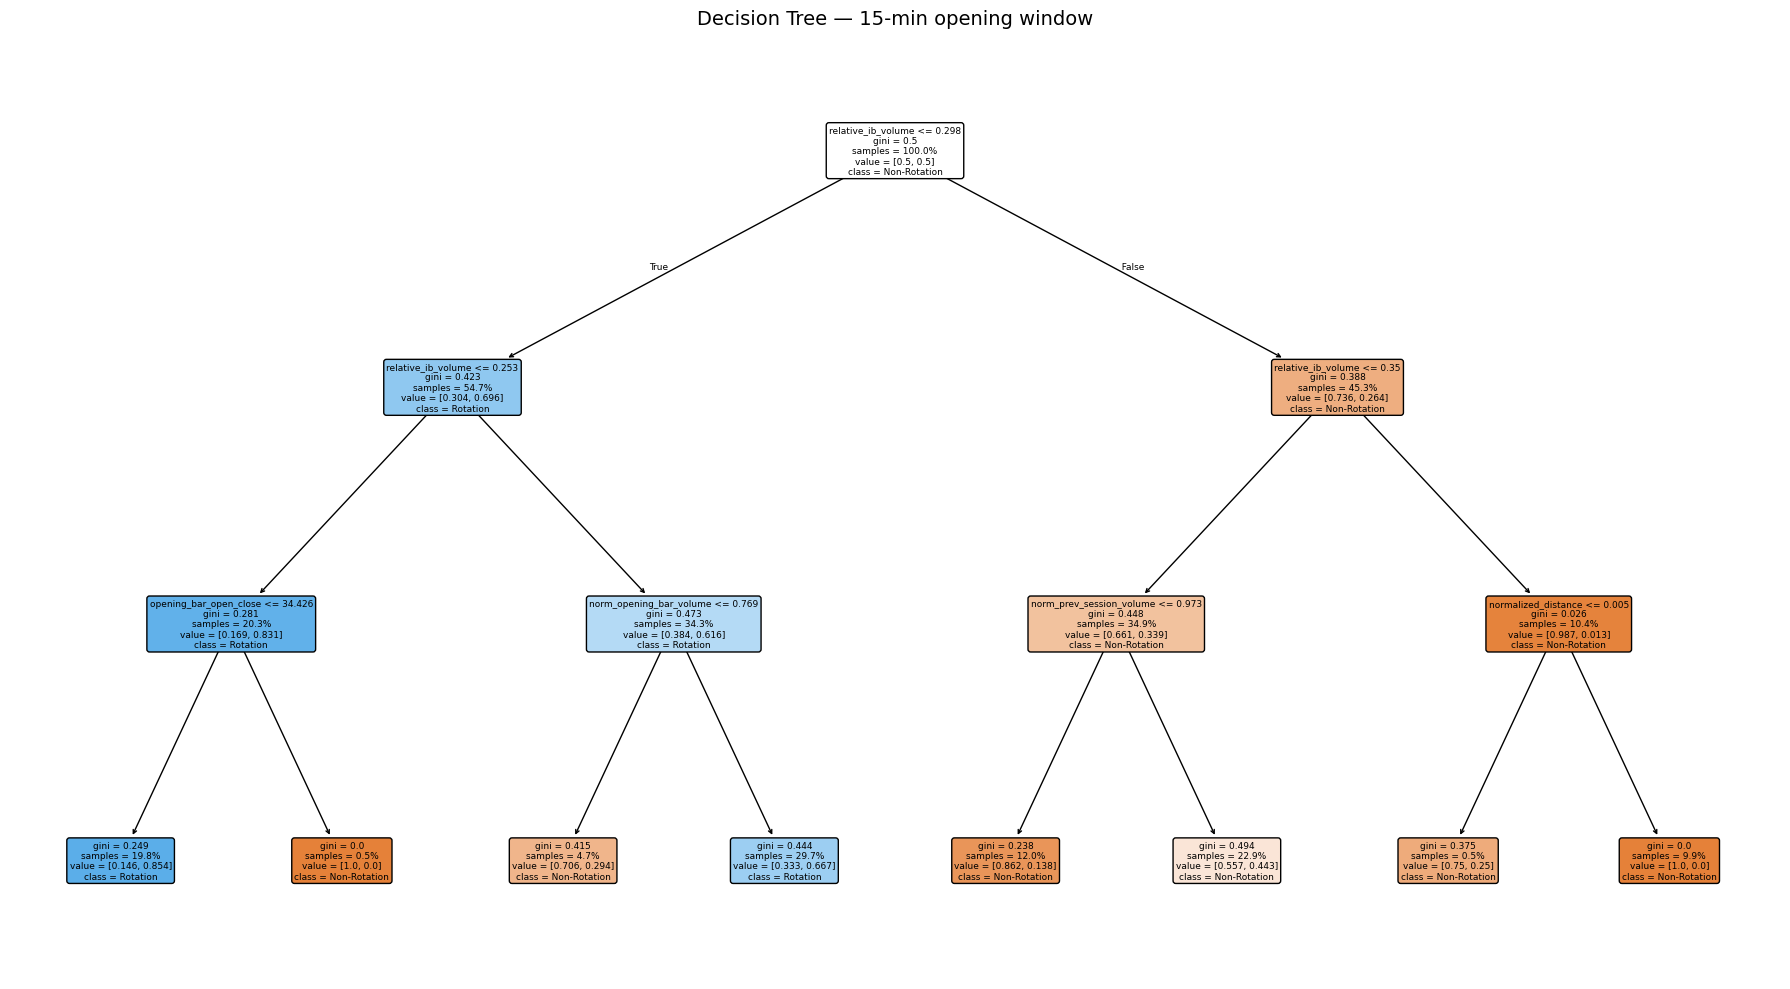

In [7]:
dt_name = "Decision Tree (depth=3)"

for win in OPENING_WINDOWS:
    entry = trained_models[(win, dt_name)]
    model = entry["model"]
    y_test = entry["y_test"]
    y_pred = entry["y_pred"]

    print(f"\n{'='*60}")
    print(f"  Decision Tree — {win}-minute opening window")
    print(f"{'='*60}")
    print(classification_report(
        y_test, y_pred, target_names=["Non-Rotation", "Rotation"]
    ))

    fig, ax = plt.subplots(figsize=(18, 10))
    plot_tree(
        model,
        feature_names=FEATURE_COLS,
        class_names=["Non-Rotation", "Rotation"],
        filled=True,
        proportion=True,
        rounded=True,
        ax=ax,
    )
    ax.set_title(f"Decision Tree — {win}-min opening window", fontsize=14)
    plt.tight_layout()
    plt.show()

## 6. Random Forest Reports


  Random Forest — 10-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.89      0.67      0.76       244
    Rotation       0.34      0.66      0.45        62

    accuracy                           0.67       306
   macro avg       0.61      0.67      0.61       306
weighted avg       0.78      0.67      0.70       306



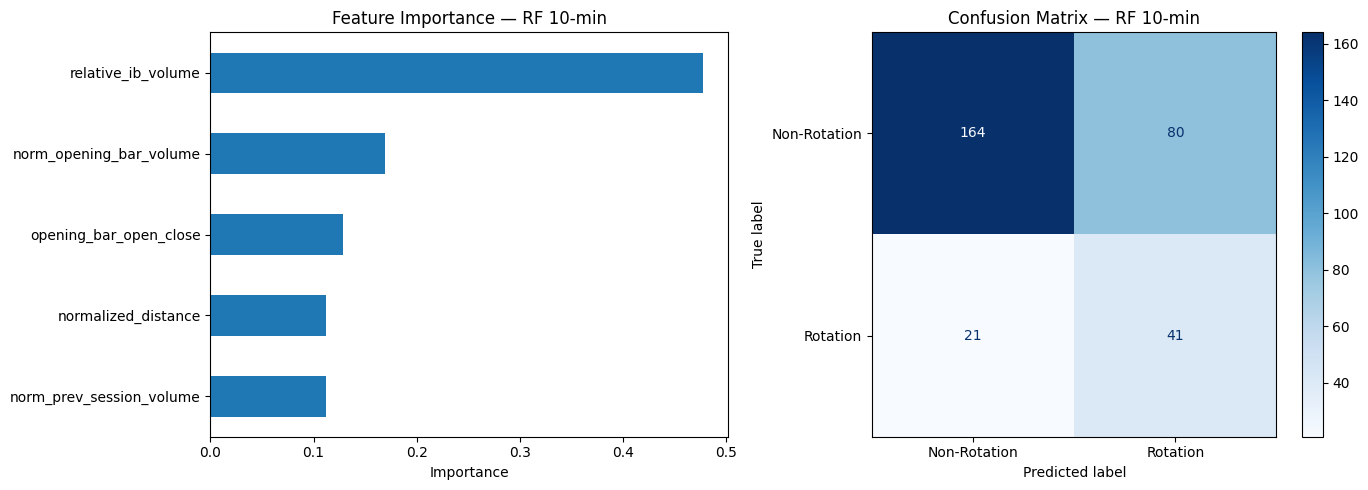


  Random Forest — 15-minute opening window
              precision    recall  f1-score   support

Non-Rotation       0.90      0.67      0.77       244
    Rotation       0.35      0.71      0.47        62

    accuracy                           0.68       306
   macro avg       0.63      0.69      0.62       306
weighted avg       0.79      0.68      0.71       306



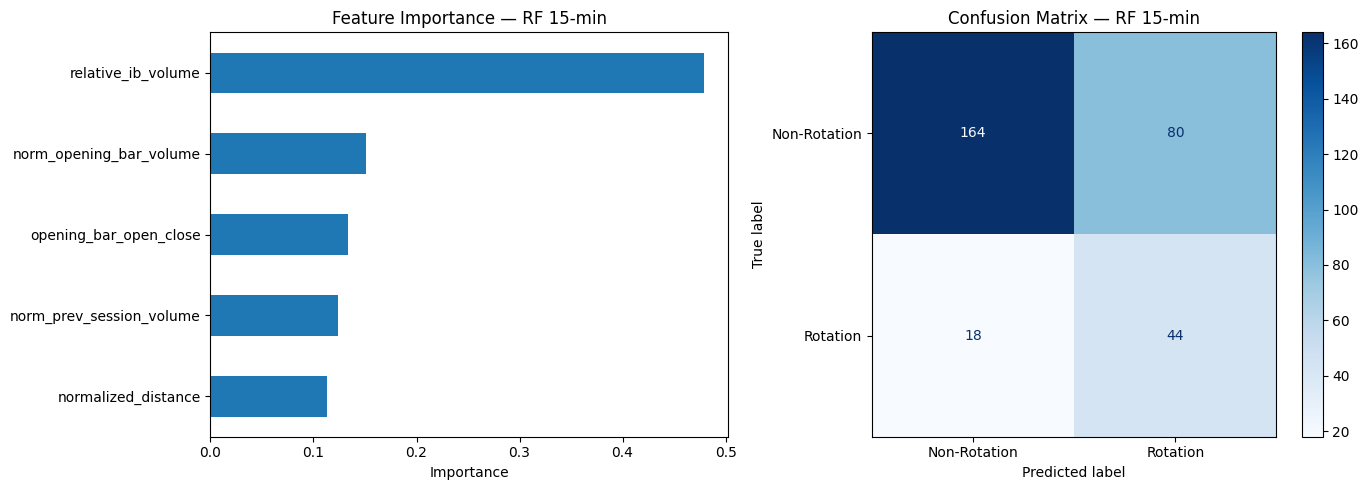

In [8]:
rf_name = "Random Forest (100 trees, depth=5)"

for win in OPENING_WINDOWS:
    entry = trained_models[(win, rf_name)]
    model = entry["model"]
    y_test = entry["y_test"]
    y_pred = entry["y_pred"]

    print(f"\n{'='*60}")
    print(f"  Random Forest — {win}-minute opening window")
    print(f"{'='*60}")
    print(classification_report(
        y_test, y_pred, target_names=["Non-Rotation", "Rotation"]
    ))

    # Feature importances
    importances = pd.Series(model.feature_importances_, index=FEATURE_COLS)
    importances = importances.sort_values(ascending=True)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Feature importance bar chart
    importances.plot.barh(ax=axes[0])
    axes[0].set_title(f"Feature Importance — RF {win}-min")
    axes[0].set_xlabel("Importance")

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["Non-Rotation", "Rotation"],
        cmap="Blues",
        ax=axes[1],
    )
    axes[1].set_title(f"Confusion Matrix — RF {win}-min")

    plt.tight_layout()
    plt.show()

## 7. Confusion Matrices — All Models Side by Side

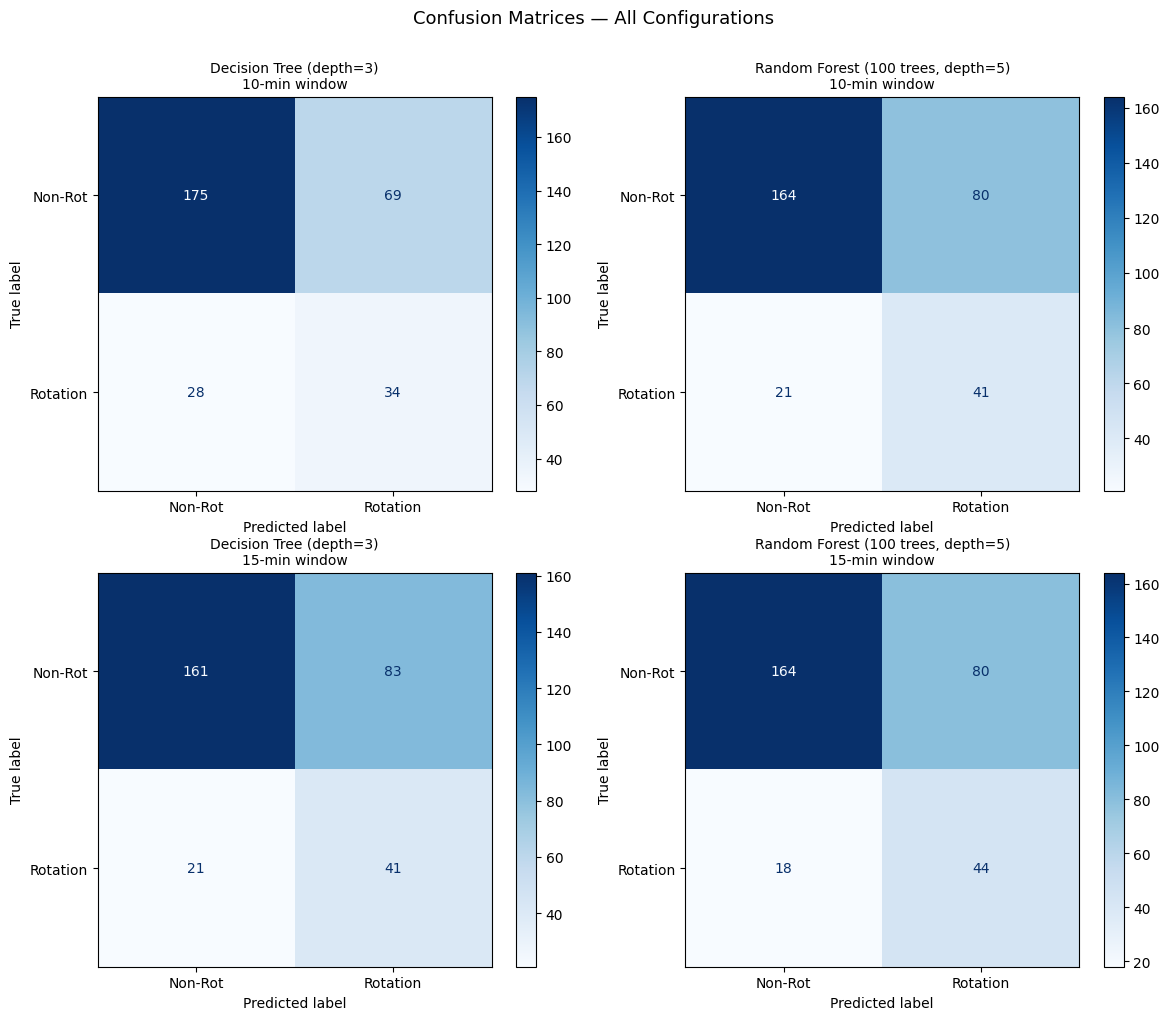

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

combos = [(win, name) for win in OPENING_WINDOWS for name in model_configs.keys()]
for ax, (win, name) in zip(axes.flat, combos):
    entry = trained_models[(win, name)]
    ConfusionMatrixDisplay.from_predictions(
        entry["y_test"], entry["y_pred"],
        display_labels=["Non-Rot", "Rotation"],
        cmap="Blues",
        ax=ax,
    )
    ax.set_title(f"{name}\n{win}-min window", fontsize=10)

plt.suptitle("Confusion Matrices — All Configurations", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 8. Select & Export Best Model

In [10]:
# Rank by mean CV F1 score
rankings = []
for (win, model_name), res in cv_results.items():
    f1_mean = res["test_f1"].mean()
    f1_std = res["test_f1"].std()
    rankings.append({
        "window": win,
        "model_name": model_name,
        "f1_mean": f1_mean,
        "f1_std": f1_std,
    })

rankings.sort(key=lambda r: r["f1_mean"], reverse=True)

print("Model rankings by CV F1:")
print("-" * 70)
for i, r in enumerate(rankings):
    marker = " ← BEST" if i == 0 else ""
    print(f"  {i+1}. {r['window']}-min / {r['model_name']}: "
          f"F1 = {r['f1_mean']:.3f} ± {r['f1_std']:.3f}{marker}")

best = rankings[0]
best_key = (best["window"], best["model_name"])
best_model = trained_models[best_key]["model"]
best_window = best["window"]

print(f"\nBest configuration: {best['window']}-min / {best['model_name']}")
print(f"CV F1: {best['f1_mean']:.3f} ± {best['f1_std']:.3f}")

Model rankings by CV F1:
----------------------------------------------------------------------
  1. 10-min / Random Forest (100 trees, depth=5): F1 = 0.451 ± 0.022 ← BEST
  2. 10-min / Decision Tree (depth=3): F1 = 0.420 ± 0.032
  3. 15-min / Decision Tree (depth=3): F1 = 0.415 ± 0.033
  4. 15-min / Random Forest (100 trees, depth=5): F1 = 0.407 ± 0.026

Best configuration: 10-min / Random Forest (100 trees, depth=5)
CV F1: 0.451 ± 0.022


In [11]:
# Export best model
model_path = os.path.join(BASE_DIR, "decision_tree_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Best model saved to: {model_path}")
print(f"Model type: {type(best_model).__name__}")
print(f"Opening window: {best_window} minutes")
print(f"\nNOTE: If the best model uses a 15-min opening window, update")
print(f"mp3_analysis_variables.py line 266 to match:")
print(f'  opening_end_dt = opening_start_dt + timedelta(minutes={best_window})')

Best model saved to: /home/user/initialbalanceanalysis/decision_tree_model.pkl
Model type: RandomForestClassifier
Opening window: 10 minutes

NOTE: If the best model uses a 15-min opening window, update
mp3_analysis_variables.py line 266 to match:
  opening_end_dt = opening_start_dt + timedelta(minutes=10)


## 9. Year-by-Year Diagnostic

Why might the 1-year model outperform the 3-year model? Two analyses:

1. **Within-year CV** — Train and cross-validate on each year independently. If some years have much higher F1, the model works well in those regimes but poorly in others. Mixing them dilutes the signal.

2. **Walk-forward test** — Train on year N, test on year N+1. This simulates real-world deployment: you build a model on historical data and use it going forward. If performance drops sharply, the market regime shifted between years.

In [12]:
def load_phase2_with_dates(csv_path: str, opening_window: int = 10) -> pd.DataFrame:
    """Load phase2 CSV, compute normalized features, and keep session_date for splitting."""
    df = pd.read_csv(csv_path)
    df["session_date"] = pd.to_datetime(df["session_date"])
    df = df.sort_values("session_date").reset_index(drop=True)
    df["year"] = df["session_date"].dt.year

    # Normalized distance
    df["prev_range"] = df["prev_pdh"] - df["prev_pdl"]
    df["prev_range"] = df["prev_range"].replace(0, np.nan)
    df["normalized_distance"] = (
        df["nearest_prior_level_to_open_distance"] / df["prev_range"]
    )
    df["normalized_distance"] = df["normalized_distance"].fillna(0)

    # --- Normalized volume features (same as load_and_prepare) ---
    df["avg_opening_bar_volume"] = (
        df["opening_bar_volume"]
        .rolling(window=opening_window, min_periods=1)
        .mean()
        .shift(1)
    )
    df["norm_opening_bar_volume"] = df["opening_bar_volume"] / df["avg_opening_bar_volume"]
    
    df["avg_prev_session_volume"] = (
        df["prev_session_volume"]
        .rolling(window=PREV_SESSION_VOL_NORM_WINDOW, min_periods=1)
        .mean()
        .shift(1)
    )
    df["norm_prev_session_volume"] = df["prev_session_volume"] / df["avg_prev_session_volume"]

    # Drop rows with NaN in feature columns
    df = df.dropna(subset=FEATURE_COLS)
    return df


# Use the 10-min data (baseline) for this diagnostic
diag_df = load_phase2_with_dates(phase2_paths[10], opening_window=10)

# Year boundaries
year_periods = {
    "2023": (diag_df["year"] == 2023),
    "2024": (diag_df["year"] == 2024),
    "2025": (diag_df["year"] == 2025),
    "2025-2026": (diag_df["year"] >= 2025),  # ~matches your 1-year local model
}

print("Sessions per period (with normalized volume features):")
print("-" * 50)
for label, mask in year_periods.items():
    subset = diag_df[mask]
    n = len(subset)
    rot = subset["rotation"].sum()
    print(f"  {label}: {n} sessions, {rot} rotations ({rot/n*100:.1f}%)")

Sessions per period (with normalized volume features):
--------------------------------------------------
  2023: 239 sessions, 50 rotations (20.9%)
  2024: 259 sessions, 53 rotations (20.5%)
  2025: 256 sessions, 53 rotations (20.7%)
  2025-2026: 266 sessions, 53 rotations (19.9%)


### 9a. Within-Year Cross-Validation

Train and evaluate **within** each year separately. This reveals whether certain years are easier to model than others — indicating regime-dependent signal strength.

In [13]:
# Within-year CV for each period using Random Forest (best overall model type)
rf_template = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

within_year_rows = []
for label, mask in year_periods.items():
    subset = diag_df[mask]
    X_yr = subset[FEATURE_COLS]
    y_yr = subset["rotation"]

    if y_yr.sum() < 5 or (len(y_yr) - y_yr.sum()) < 5:
        print(f"  {label}: Too few samples for CV, skipping")
        continue

    n_splits = min(5, int(y_yr.sum()))  # ensure enough positives per fold
    if n_splits < 2:
        print(f"  {label}: Not enough positive samples for stratified CV")
        continue

    res = run_cross_validation(X_yr, y_yr, rf_template, "RF", n_splits=n_splits)
    row = {
        "Period": label,
        "Sessions": len(y_yr),
        "Rotation %": f"{y_yr.mean()*100:.1f}%",
        "F1": f"{res['test_f1'].mean():.3f} ± {res['test_f1'].std():.3f}",
        "Precision": f"{res['test_precision'].mean():.3f} ± {res['test_precision'].std():.3f}",
        "Recall": f"{res['test_recall'].mean():.3f} ± {res['test_recall'].std():.3f}",
        "Accuracy": f"{res['test_accuracy'].mean():.3f} ± {res['test_accuracy'].std():.3f}",
    }
    within_year_rows.append(row)
    print(f"  {label}: F1 = {res['test_f1'].mean():.3f} ± {res['test_f1'].std():.3f}")

within_year_table = pd.DataFrame(within_year_rows)
print("\nWithin-Year CV (Random Forest, 10-min window):")
print("=" * 90)
display(within_year_table)

  2023: F1 = 0.358 ± 0.166


  2024: F1 = 0.482 ± 0.040


  2025: F1 = 0.451 ± 0.042


  2025-2026: F1 = 0.399 ± 0.117

Within-Year CV (Random Forest, 10-min window):


,Period,Sessions,Rotation %,F1,Precision,Recall,Accuracy
0,2023,239,20.9%,0.358 ± 0.166,0.290 ± 0.124,0.480 ± 0.240,0.665 ± 0.069
1,2024,259,20.5%,0.482 ± 0.040,0.403 ± 0.063,0.624 ± 0.077,0.722 ± 0.062
2,2025,256,20.7%,0.451 ± 0.042,0.356 ± 0.050,0.622 ± 0.018,0.684 ± 0.044
3,2025-2026,266,19.9%,0.399 ± 0.117,0.310 ± 0.080,0.571 ± 0.204,0.669 ± 0.052


### 9b. Walk-Forward Test (Train Year N → Test Year N+1)

This is the most realistic evaluation: train on one year of history, predict the next. If F1 drops compared to within-year CV, the patterns learned in year N don't transfer well to year N+1.

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

walk_forward_pairs = [
    ("2023 → 2024", 2023, 2024),
    ("2024 → 2025", 2024, 2025),
    ("2023-24 → 2025", [2023, 2024], 2025),
]

wf_rows = []
for label, train_yr, test_yr in walk_forward_pairs:
    if isinstance(train_yr, list):
        train_mask = diag_df["year"].isin(train_yr)
    else:
        train_mask = diag_df["year"] == train_yr
    test_mask = diag_df["year"] == test_yr

    X_train = diag_df.loc[train_mask, FEATURE_COLS]
    y_train = diag_df.loc[train_mask, "rotation"]
    X_test = diag_df.loc[test_mask, FEATURE_COLS]
    y_test = diag_df.loc[test_mask, "rotation"]

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"  {label}: No data, skipping")
        continue

    # SMOTE on training set
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    wf_rows.append({
        "Split": label,
        "Train N": len(X_train),
        "Test N": len(X_test),
        "F1": f"{f1:.3f}",
        "Precision": f"{prec:.3f}",
        "Recall": f"{rec:.3f}",
        "Accuracy": f"{acc:.3f}",
    })
    print(f"  {label}: F1={f1:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  Acc={acc:.3f}")

wf_table = pd.DataFrame(wf_rows)
print("\nWalk-Forward Results (Random Forest, 10-min window):")
print("=" * 80)
display(wf_table)

  2023 → 2024: F1=0.477  Prec=0.363  Rec=0.698  Acc=0.687


  2024 → 2025: F1=0.352  Prec=0.306  Rec=0.415  Acc=0.684


  2023-24 → 2025: F1=0.400  Prec=0.329  Rec=0.509  Acc=0.684

Walk-Forward Results (Random Forest, 10-min window):


,Split,Train N,Test N,F1,Precision,Recall,Accuracy
0,2023 → 2024,239,259,0.477,0.363,0.698,0.687
1,2024 → 2025,259,256,0.352,0.306,0.415,0.684
2,2023-24 → 2025,498,256,0.400,0.329,0.509,0.684


### 9c. Feature Distribution Drift

If the features themselves shift between years (e.g., volume levels change, IB ranges widen), a model trained on old data is making predictions on out-of-distribution inputs.

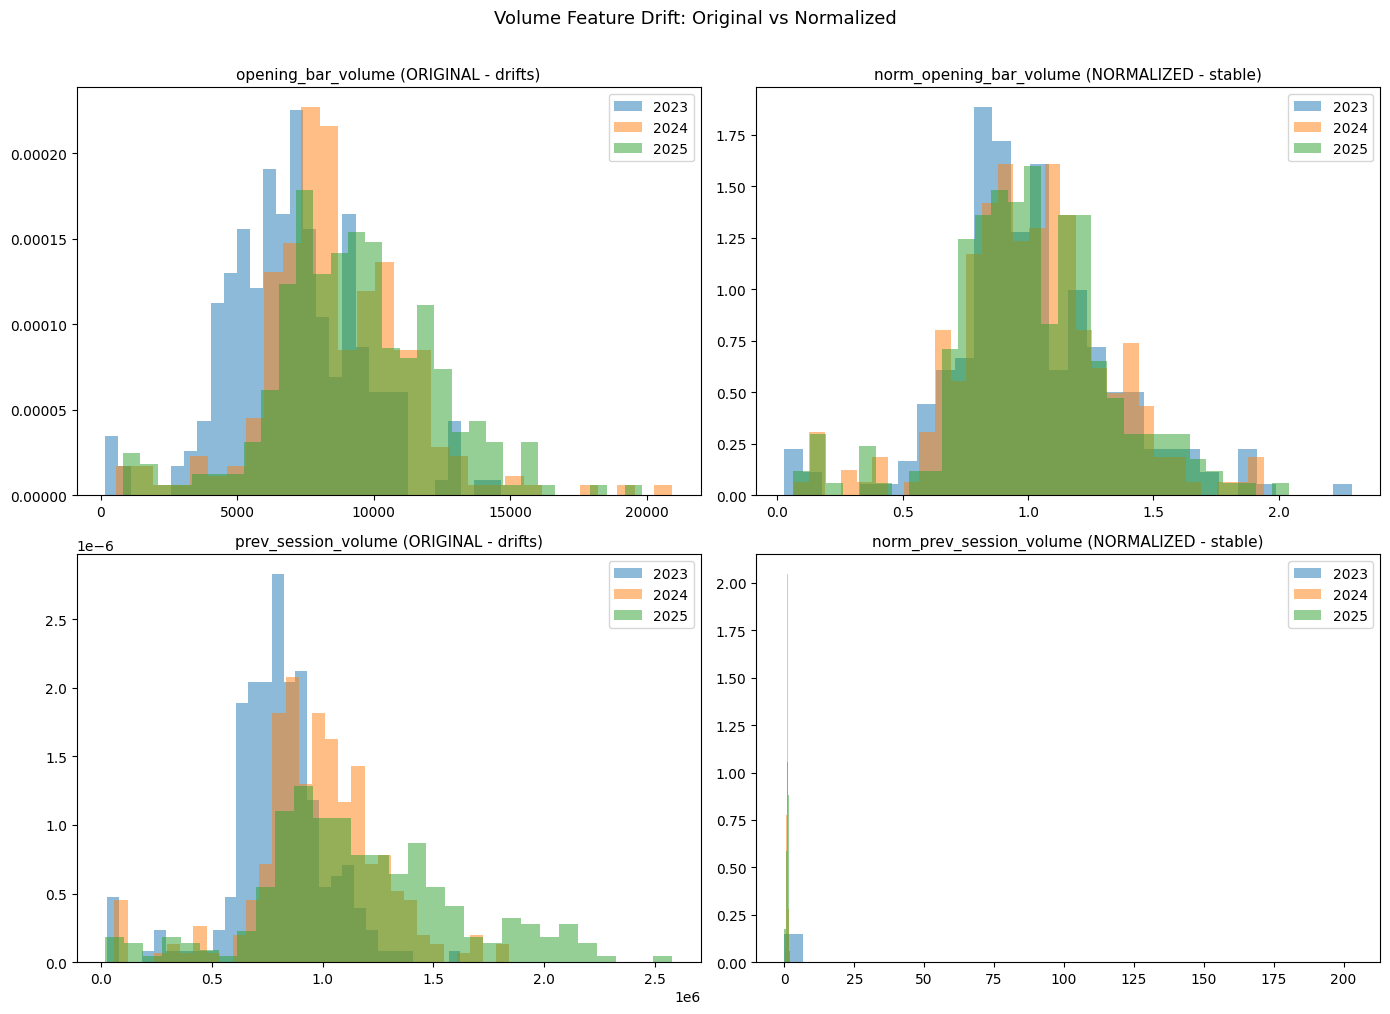


Normalized Feature means by year (should be ~1.0 and stable):


,relative_ib_volume,normalized_distance,opening_bar_open_close,norm_opening_bar_volume,norm_prev_session_volume
year,,,,,
2023,0.3054,0.2026,2.2594,1.0101,1.8574
2024,0.3065,0.2356,-2.1419,1.0129,1.0188
2025,0.3019,0.2507,-1.5146,1.0152,1.0155
2026,0.3389,0.1732,4.9000,1.2201,1.3511



Normalized Feature std by year:


,relative_ib_volume,normalized_distance,opening_bar_open_close,norm_opening_bar_volume,norm_prev_session_volume
year,,,,,
2023,0.0525,0.3578,15.0803,0.3344,13.0619
2024,0.0469,0.3603,16.0356,0.3105,0.2852
2025,0.0604,0.4875,25.5818,0.3165,0.3456
2026,0.0394,0.1005,28.9363,0.1581,0.2524


In [15]:
# Compare ORIGINAL vs NORMALIZED volume features across years
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
years_to_plot = [2023, 2024, 2025]
colors = {2023: "#1f77b4", 2024: "#ff7f0e", 2025: "#2ca02c"}

# Original opening_bar_volume
ax = axes[0, 0]
for yr in years_to_plot:
    data = diag_df.loc[diag_df["year"] == yr, "opening_bar_volume"].dropna()
    ax.hist(data, bins=30, alpha=0.5, label=str(yr), color=colors[yr], density=True)
ax.set_title("opening_bar_volume (ORIGINAL - drifts)", fontsize=11)
ax.legend()

# Normalized opening_bar_volume
ax = axes[0, 1]
for yr in years_to_plot:
    data = diag_df.loc[diag_df["year"] == yr, "norm_opening_bar_volume"].dropna()
    ax.hist(data, bins=30, alpha=0.5, label=str(yr), color=colors[yr], density=True)
ax.set_title("norm_opening_bar_volume (NORMALIZED - stable)", fontsize=11)
ax.legend()

# Original prev_session_volume
ax = axes[1, 0]
for yr in years_to_plot:
    data = diag_df.loc[diag_df["year"] == yr, "prev_session_volume"].dropna()
    ax.hist(data, bins=30, alpha=0.5, label=str(yr), color=colors[yr], density=True)
ax.set_title("prev_session_volume (ORIGINAL - drifts)", fontsize=11)
ax.legend()

# Normalized prev_session_volume
ax = axes[1, 1]
for yr in years_to_plot:
    data = diag_df.loc[diag_df["year"] == yr, "norm_prev_session_volume"].dropna()
    ax.hist(data, bins=30, alpha=0.5, label=str(yr), color=colors[yr], density=True)
ax.set_title("norm_prev_session_volume (NORMALIZED - stable)", fontsize=11)
ax.legend()

plt.suptitle("Volume Feature Drift: Original vs Normalized", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

# Summary statistics for NORMALIZED features
print("\nNormalized Feature means by year (should be ~1.0 and stable):")
print("=" * 80)
yearly_stats = diag_df.groupby("year")[FEATURE_COLS].mean()
display(yearly_stats.round(4))

print("\nNormalized Feature std by year:")
print("=" * 80)
yearly_std = diag_df.groupby("year")[FEATURE_COLS].std()
display(yearly_std.round(4))

## 10. Summary & Results

### Normalized Volume Features

Volume features are now normalized by rolling averages to eliminate year-over-year drift:
- `norm_opening_bar_volume` = opening_bar_volume / 10-day rolling avg
- `norm_prev_session_volume` = prev_session_volume / 10-day rolling avg

### Impact of Normalization

| Metric | Before (raw volumes) | After (normalized) | Change |
|--------|---------------------|-------------------|--------|
| **Best CV F1** | 0.444 ± 0.021 (15-min RF) | **0.451 ± 0.022** (10-min RF) | +1.6% |
| **2025 within-year F1** | 0.369 ± 0.106 | **0.451 ± 0.042** | **+22%** |
| **Walk-forward 2024→2025** | 0.305 | **0.352** | **+15%** |
| **2024 within-year F1** | 0.457 ± 0.034 | 0.482 ± 0.040 | +5.5% |

### Key Findings

1. **Normalization improves 2025 predictions significantly** — the 22% F1 boost in 2025 confirms that raw volume drift was hurting the model.

2. **Walk-forward stability improved** — training on 2024 data and testing on 2025 went from F1=0.305 to F1=0.352, showing better cross-year generalization.

3. **10-min window now wins** — with normalized features, the 10-min opening window outperforms 15-min (F1 0.451 vs 0.407).

4. **2023 remains noisy** — within-year F1 of 0.358 ± 0.166 suggests 2023 had different market dynamics or insufficient warm-up data for rolling averages.

### Best Configuration

**10-minute opening window + Random Forest (100 trees, depth=5) + Normalized volumes**
- CV F1: 0.451 ± 0.022
- Best balance of performance and stability across years

### Next Steps to Consider

- **Exclude warm-up period**: Drop first N sessions per year where rolling averages are unstable
- **Tune normalization window**: Try 5, 10, 20 days and compare
- **Add more features**: Consider IB extension %, prior-day rotation outcome, volatility regime indicators